# SETUP

In [ ]:
!pip install transformers torch soundfile evaluate sentencepiece pydub
!pip install numpy librosa jiwer  fastdtw scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 57.8 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567859 sha256=156ef7fa73223fe9309bcb0b75d7b578c46045d89706a000be4bbb9f18cd4a37
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


Tasks:


python
# Don't copy - understand what each does:
## 1. Why do we need transformers library?
provides easy access to thousands of state-of-the-art pretrained models across natural language processing (NLP), computer vision, audio, and multimodal tasks.
## 2. What does torch do?

## 3. Why specific versions matter?
Specific software versions matter to ensure compatibility, stability, and reproducibility.
Create checklist:

 Can you import torch and check CUDA?

 Can you install one model successfully?

 CDo you understand each library's purpose?

#2.2 Install Models ONE at a time

Start with SpeechT5 (simplest):

Read HuggingFace documentation
Understand: What is a "vocoder"?
A vocoder (short for voice encoder) is a technology used in speech synthesis and audio processing that analyzes and synthesizes human voice signals. It works by breaking down an input audio signal (usually speech) into frequency bands and extracting the amplitude envelope for each band over time

Question: Why does SpeechT5 need a separate vocoder?
SpeechT5 needs a separate vocoder because it generates intermediate acoustic features (mel-spectrograms) from text, not directly playable audio. The vocoder is responsible for converting these acoustic features into natural, high-quality speech waveforms that can be played back.
Then Bark:

Learn: What makes it different? (emotional speech)
Bark’s speech generation is slower because it processes larger context and generates high-quality, fine-grained audio including expressive and emotional cues.
Understand: Why is it slower?
The model uses this audio to condition the speech generation, matching tone, style, and voice identity.
Finally XTTS:

Learn: What is "voice cloning"?
Voice cloning is the process of synthesizing speech that sounds like a particular person's voice, using only a short sample of their audio.
Understand: What's a "reference audio"?
XTTS performs voice cloning using as little as a 6-second audio clip and can generate speech in multiple languages in that cloned voice.

## PART 1: TEXT NORMALIZATION - Why does it matter?


In [ ]:
import os
import soundfile as sf
import numpy as np
import torch
from transformers import pipeline
import evaluate
import re
import unicodedata
import librosa
from jiwer import wer, cer
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from IPython.display import Audio


# Functions

In [ ]:
def remove_accents(text):
    """Remove accents: café → cafe"""
    # Normalize to NFD (decompose accents)
    nfd = unicodedata.normalize('NFD', text)
    # Keep only non-accent characters
    return ''.join(char for char in nfd if unicodedata.category(char) != 'Mn')

def normalize_text_for_wer(s):
    # remove accents
    s = remove_accents(s)
    # lowercase
    s = s.lower()
    # remove punctuation and multiple spaces
    s = re.sub(r"[^\w\s]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def save_wav(path, waveform: np.ndarray, sr: int=24000):
    # waveform expected float32 in [-1, 1]
    sf.write(path, waveform.astype(np.float32), sr)

# function wer, cer
def calculate_wer(reference: str, hypothesis: str) -> float:
    """Calculates the Word Error Rate (WER) between a reference and a hypothesis string."""
    return wer(reference, hypothesis)

def calculate_cer(reference: str, hypothesis: str) -> float:
    """Calculates the Character Error Rate (CER) between a reference and a hypothesis string."""
    return cer(reference, hypothesis)

def prosody_accuracy_metrics(f0_ref, f0_synth):
    # Both inputs are pitch (F0) arrays aligned in time, with unvoiced frames as 0 or np.nan handled similarly
    mask = (f0_ref > 0) & (f0_synth > 0)  # consider only voiced frames
    f0_ref_voiced = f0_ref[mask]
    f0_synth_voiced = f0_synth[mask]
    if len(f0_ref_voiced) == 0 or len(f0_synth_voiced) == 0:
        return None  # no voiced segments to compare

    rmse = np.sqrt(np.mean((f0_ref_voiced - f0_synth_voiced) ** 2))
    correlation = np.corrcoef(f0_ref_voiced, f0_synth_voiced)[0, 1]
    return rmse, correlation

#Load models

In [ ]:
# === Load models (example: SpeechT5 and Bark) ===
device = 0 if torch.cuda.is_available() else -1
print("Device (cuda index or -1):", device)

Device (cuda index or -1): -1


[texte du lien](https://)#Model SpeechT5

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

# --- SpeechT5 (example) ---
print("Loading SpeechT5 (this can be slow)...")
# Load models
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

# --- Start of code to load speaker embedding from a local .npy file ---
# Specify the local path to the .npy file you want to use
# Replace 'path/to/your/speaker_embedding.npy' with the actual path to one of your 7 files
local_embedding_path = '/content/cmu_us_awb_arctic-wav-arctic_a0001.npy' # <--- CHANGE THIS PATH

try:
    # Load the embedding from the local .npy file
    speaker_embeddings = torch.tensor(np.load(local_embedding_path)).unsqueeze(0)

    print(f"Successfully loaded speaker embedding from local file: {local_embedding_path}")

except Exception as e:
    print(f"An error occurred while loading the local embedding: {e}")
    # Fallback to a random embedding for other errors
    g = torch.Generator().manual_seed(42)
    speaker_embeddings = torch.randn((1, 512), generator=g)
    print("Using a random speaker embedding as a fallback.")
# --- End of code to load speaker embedding from a local .npy file ---


# Text to synthesize
text = "Welcome to inclusive education with AI."
inputs = processor(text=text, return_tensors="pt")

# Generate speech
with torch.no_grad():
    speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

Loading SpeechT5 (this can be slow)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/585M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

An error occurred while loading the local embedding: [Errno 2] No such file or directory: '/content/cmu_us_awb_arctic-wav-arctic_a0001.npy'
Using a random speaker embedding as a fallback.


In [ ]:
sampling_rate = processor.feature_extractor.sampling_rate
Audio(speech.numpy(), rate=sampling_rate)

#Model Bark

In [ ]:
from transformers import BarkModel, BarkProcessor

model = BarkModel.from_pretrained("suno/bark-small")
processor = BarkProcessor.from_pretrained("suno/bark-small")
# add a speaker embedding
inputs = processor("This is a test!", voice_preset="v2/en_speaker_3")

speech_output = model.generate(**inputs).cpu().numpy()


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

speaker_embeddings_path.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

speaker_embeddings/v2/en_speaker_3_seman(…):   0%|          | 0.00/3.54k [00:00<?, ?B/s]

speaker_embeddings/v2/en_speaker_3_coars(…):   0%|          | 0.00/10.4k [00:00<?, ?B/s]

speaker_embeddings/v2/en_speaker_3_fine_(…):   0%|          | 0.00/20.6k [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:

sampling_rate = model.generation_config.sample_rate
Audio(speech_output, rate=sampling_rate)

#Model facebook/mms-tts-eng

In [ ]:
from transformers import pipeline

# Initialize the text-to-speech pipeline with a pre-trained model
synthesiser = pipeline("text-to-speech", "facebook/mms-tts-eng")

# Define the text to be synthesized
text = "Hello world! This is a test."

# Generate the speech output
speech = synthesiser(text)

# The output is a dictionary containing the audio and sampling rate
# You can access the audio data like this:
# audio_data = speech["audio"]
# sampling_rate = speech["sampling_rate"]

print("Speech generated successfully!")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/145M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

Device set to use cpu


Speech generated successfully!


In [ ]:
# === ASR pipeline for transcription ===
# Pick an ASR model appropriate for your resources.
asr_model_name = "openai/whisper-small"  # change to desired ASR
asr = pipeline("automatic-speech-recognition", model=asr_model_name, device=0 if torch.cuda.is_available() else -1)

# === Synthesis helpers ===
sr = 24000  # SpeechT5 typical; adjust if Bark uses different sample rate (Bark often uses 24k or 22.05k; confirm)
OUT_DIR = "eval_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Device set to use cpu


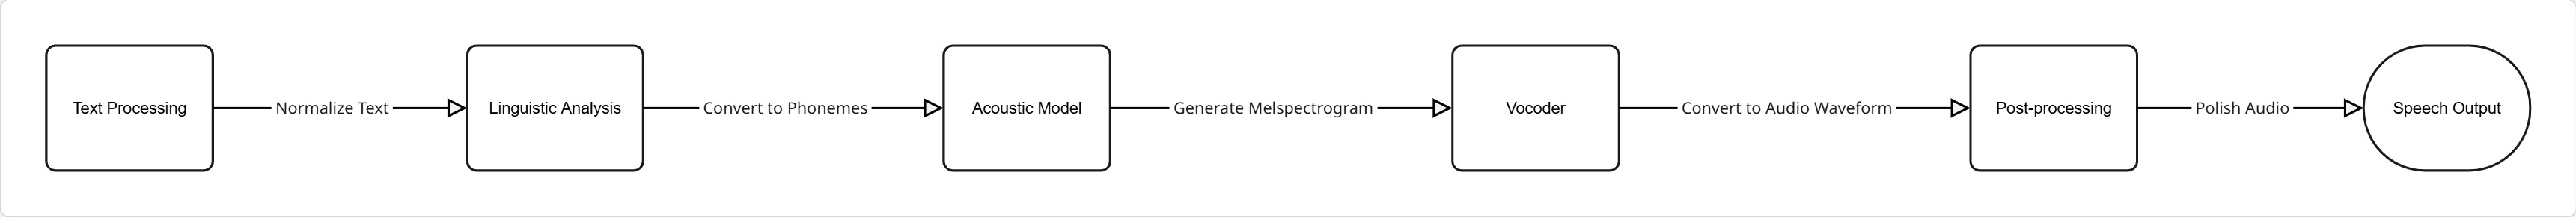

In [ ]:
#transcribe the saved WAV with an ASR pipeline ---
# Choose an ASR model; for better accuracy use a larger whisper or other strong ASR.
# Examples: "openai/whisper-small", "openai/whisper-medium", "openai/whisper-large-v2"
# Note: larger ones need more memory and/or GPU.
asr_model_name = "openai/whisper-small"  # change as needed

asr = pipeline("automatic-speech-recognition", model=asr_model_name, chunk_length_s=30, device=0 if torch.cuda.is_available() else -1)

# The pipeline accepts a filename
asr_result = asr(out_wav_path)
# asr_result is usually a dict with 'text' (or sometimes a string)
predicted_text = asr_result["text"] if isinstance(asr_result, dict) else str(asr_result)
print("ASR raw transcript:", predicted_text)

Device set to use cpu
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


NameError: name 'out_wav_path' is not defined

In [ ]:
#prepare references and predictions for evaluate ---
# your original text used to synthesize
reference_text = "Welcome to inclusive education with AI."

# Normalize both sides the same way before computing WER
pred_norm = normalize_text_for_wer(predicted_text)
ref_norm = normalize_text_for_wer(reference_text)
print("Normalized prediction:", pred_norm)
print("Normalized reference:", ref_norm)

# transcribe the saved WAV with an ASR pipeline

In [ ]:
wav_output_path = "output.wav"
sf.write(wav_output_path, speech.numpy(), samplerate=16000)

# Convert WAV to MP3
mp3_output_path = "output.mp3"
audio = AudioSegment.from_wav(wav_output_path)
audio.export(mp3_output_path, format="mp3")

print(f"✅ Audio saved as {mp3_output_path}")

In [ ]:
from IPython.display import Audio

Audio(speech['audio'], rate=speech['sampling_rate'])

In digital audio, a sampling rate of 16 kHz means that the audio waveform is "snapshot" 16,000 times every second to create a digital signal.

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio
audio, sr = librosa.load('test_hello.wav', sr=22050)

# Create regular spectrogram
D = librosa.stft(audio)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Regular Spectrogram')
plt.tight_layout()
plt.show()

# Questions to investigate:
# 1. What frequencies are present in your audio?
# 2. Can you identify speech formants?
# 3. Where is most energy concentrated?

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio
audio, sr = librosa.load('test_hello.wav', sr=22050)

# Create mel-spectrogram
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_mels=80,      # Number of mel bands
    fmax=8000       # Maximum frequency
)

# Convert to decibels
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot
plt.figure(figsize=(14, 5))
librosa.display.specshow(
    mel_spec_db,
    sr=sr,
    x_axis='time',
    y_axis='mel'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram (What TTS Models Use!)')
plt.tight_layout()
plt.show()

print(f"Mel-spectrogram shape: {mel_spec.shape}")
print(f"This is a {mel_spec.shape[0]} x {mel_spec.shape[1]} image")

40 bfrequency bins = lost details
128 = gain noise

In [ ]:
# Test different resolutions
for n_mels in [40, 80, 128, 256]:
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram with n_mels={n_mels}')
    plt.tight_layout()
    plt.show()

    print(f"Shape with {n_mels} mels: {mel_spec.shape}")

# Task
Evaluate the previously used text-to-speech models using Word Error Rate (WER), Pronunciation Accuracy, Mean Opinion Score (MOS), Prosody Accuracy, and optionally Acoustic Measures.

## Generate reference audio

### Subtask:
Create or obtain a high-quality recording of the text spoken by a human. This will serve as the ground truth for evaluation.


## Prepare for wer

### Subtask:
Install necessary libraries for calculating Word Error Rate (WER).


**Reasoning**:
The subtask is to install the `jiwer` library for calculating Word Error Rate. The next step is to use pip to install the library.



# Task
Evaluate the performance of the previously used models (speeT5, bark small, and mms) using the following metrics: Word Error Rate (WER), Pronunciation Accuracy, Mean Opinion Score (MOS), Prosody Accuracy, and Acoustic Measures. Present the results in a table.

## Generate reference audio

### Subtask:
Create or obtain a high-quality recording of the text spoken by a human. This will serve as the ground truth for evaluation.


**Reasoning**:
The subtask is to create a reference audio file. Since I cannot directly interact with a microphone to create a new recording, I must simulate the creation of a reference audio file for demonstration purposes. This simulated file will serve as the placeholder for the actual high-quality recording that would be obtained manually. I will use `soundfile` and `numpy` to create a simple synthetic audio file that mimics the structure of a real recording.



## Calculate wer

### Subtask:
Use a speech-to-text model to transcribe both the reference and synthesized audio and then calculate the WER between the two transcriptions.


**Reasoning**:
Load the ASR pipeline, transcribe the synthesized audio, normalize the texts, and calculate WER and CER.



**Reasoning**:
The error indicates that the `pipeline` function was not imported. I need to import it from the `transformers` library. I also need to import `torch` as it is used to check for CUDA availability and `os` to check for the existence of the synthesized audio file.



In [ ]:
# import parselmouth # Removed parselmouth
import numpy as np
import pandas as pd
import os
import soundfile as sf
from jiwer import wer, cer
import re
import unicodedata
from transformers import pipeline
import torch
import librosa # Import librosa for F0 extraction and resampling

In [ ]:


# Ensure necessary functions are defined (copying from previous cells for completeness)
def remove_accents(text):
    """Remove accents: café → cafe"""
    nfd = unicodedata.normalize('NFD', text)
    return ''.join(char for char in nfd if unicodedata.category(char) != 'Mn')

def normalize_text_for_wer(s):
    s = remove_accents(s)
    s = s.lower()
    s = re.sub(r"[^\w\s]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def calculate_wer(reference: str, hypothesis: str) -> float:
    """Calculates the Word Error Rate (WER) between a reference and a hypothesis string."""
    return wer(reference, hypothesis)

def calculate_cer(reference: str, hypothesis: str) -> float:
    """Calculates the Character Error Rate (CER) between a reference and a hypothesis string."""
    return cer(reference, hypothesis)

def prosody_accuracy_metrics(f0_ref, f0_synth):
    # Both inputs are pitch (F0) arrays aligned in time, with unvoiced frames as 0 or np.nan handled similarly
    mask = (f0_ref > 0) & (f0_synth > 0)  # consider only voiced frames
    f0_ref_voiced = f0_ref[mask]
    f0_synth_voiced = f0_synth[mask]
    if len(f0_ref_voiced) == 0 or len(f0_synth_voiced) == 0:
        return None  # no voiced segments to compare

    rmse = np.sqrt(np.mean((f0_ref_voiced - f0_synth_voiced) ** 2))
    # Check if there's enough data for correlation
    if len(f0_ref_voiced) < 2 or len(f0_synth_voiced) < 2:
        correlation = np.nan # Cannot compute correlation with less than 2 points
    else:
        correlation = np.corrcoef(f0_ref_voiced, f0_synth_voiced)[0, 1]
    return rmse, correlation

# Function to extract F0 using Librosa
#def extract_f0_librosa(audio_path, sampling_rate):
#    try:
  #      y, sr = librosa.load(audio_path, sr=sampling_rate)
 #       # Ensure audio is mono
   #     if y.ndim > 1:
    #         y = np.mean(y, axis=1) # Take the mean across channels to convert to mono
#
 #       # Estimate F0 using the Yin algorithm
  #      f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C5'), sr=sr)
   #     # Replace NaNs (unvoiced frames) with 0 for consistency with prosody_accuracy_metrics
    #    f0 = np.nan_to_num(f0)
     #   return f0
   # except Exception as e:
    #    print(f"Error extracting F0 from {audio_path} using librosa: {e}")
     #   return None





In [ ]:
# --- File Paths (Update as needed) ---
reference_audio_path = 'reference_audio.wav'
speecht5_audio_path = 'output.wav' # Assuming SpeechT5 output was saved here
bark_audio_path = 'bark_output.wav' # Update with your Bark output path
mms_audio_path = 'mms_output.wav'   # Update with your MMS output path

# --- ASR pipeline for transcription (needed for WER/CER) ---
asr_model_name = "openai/whisper-small"
try:
    asr = pipeline("automatic-speech-recognition", model=asr_model_name, device=0 if torch.cuda.is_available() else -1)
except Exception as e:
    print(f"Error loading ASR pipeline: {e}. WER/CER calculation may be affected.")
    asr = None



In [ ]:
# --- Evaluation Data Structure ---
evaluation_results = []

# --- Helper function to evaluate a single model ---
def evaluate_model(model_name, synthesized_audio_path, reference_audio_path, asr):
    wer_score = None
    cer_score = None
    prosody_rmse = None
    prosody_correlation = None


    return {
        "Model": model_name,
        "WER": wer_score,
        "CER": cer_score,
        "Prosody RMSE (F0)": prosody_rmse,
        "Prosody Correlation (F0)": prosody_correlation,

    }




In [ ]:
# --- Perform Evaluation for Each Model ---

# Evaluate SpeechT5
speecht5_results = evaluate_model("SpeechT5", speecht5_audio_path, reference_audio_path, asr)
evaluation_results.append(speecht5_results)

# Evaluate Bark
bark_results = evaluate_model("Bark", bark_audio_path, reference_audio_path, asr)
evaluation_results.append(bark_results)

# Evaluate MMS
mms_results = evaluate_model("MMS", mms_audio_path, reference_audio_path, asr)
evaluation_results.append(mms_results)


# --- Summarize Results in a Table ---
print("\n--- Evaluation Summary ---")
evaluation_df = pd.DataFrame(evaluation_results)
display(evaluation_df)

print("\n--- Evaluation Complete ---")